In [1]:
import numpy as np
import astropy.io.fits as pyfits
from astropy.table import Table
import pylab
import matplotlib.pyplot as plt
import pandas as pd
import csv

In [2]:
infile_redmagic = 'Data/y3_gold_2.2.1_wide_sofcol+deep_mof_run_redmagic_highdens.fit'
reader_redmagic = pyfits.open(infile_redmagic)
#print(reader_redmagic[1].header)
d_redmagic = reader_redmagic[1].data

In [3]:
data = Table.read(infile_redmagic, format='fits')
data.info

<Table length=2766815>
     name       dtype  shape
-------------- ------- -----
            id   int64      
            ra float64      
           dec float64      
        refmag float32      
    refmag_err float32      
           mag float32  (4,)
       mag_err float32  (4,)
           lum float32      
     zredmagic float32      
   zredmagic_e float32      
zredmagic_samp float32  (4,)
         chisq float32      
         zspec float32      

In [4]:
d_redmagic = d_redmagic[d_redmagic['zspec'] > 0.]
d_redmagic = d_redmagic[d_redmagic['dec'] > -10.]
print(len(d_redmagic))

49290


In [5]:
reader_boss = pyfits.open('data/sdss_velocity_dispersion.fits')
print(reader_boss[1].header)
d_veldisp = reader_boss[1].data

XTENSION= 'BINTABLE'                                                            BITPIX  =                    8                                                  NAXIS   =                    2                                                  NAXIS1  =                   32                                                  NAXIS2  =              1169508                                                  PCOUNT  =                    0                                                  GCOUNT  =                    1                                                  TFIELDS =                    6                                                  TFORM1  = '1D'                                                                  TTYPE1  = 'ra'                                                                  TFORM2  = '1D'                                                                  TTYPE2  = 'dec'                                                                 TFORM3  = '1E'                          

In [6]:
data = Table.read('data/sdss_velocity_dispersion.fits', format='fits')
data.info

<Table length=1169508>
   name     dtype 
---------- -------
        ra float64
       dec float64
         z float32
      zErr float32
   velDisp float32
velDispErr float32

In [7]:
d_veldisp = d_veldisp[d_veldisp['dec'] < 10.]
selection = np.logical_not((d_veldisp['ra'] > 90.) & (d_veldisp['ra'] < 270.))
selection = selection & ((d_veldisp['velDisp'] / d_veldisp['velDispErr']) > 5.)
d_veldisp = d_veldisp[selection]
print(len(d_veldisp))

117545


/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


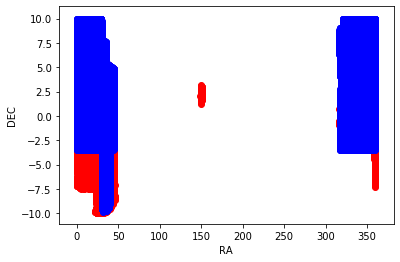

In [8]:
pylab.figure()
#plt.tittle('Both catalogs (Redmagic in red & SDSS in blue)')
plt.xlabel('RA')
plt.ylabel('DEC')
pylab.scatter(d_redmagic['ra'], d_redmagic['dec'], c='red')
pylab.scatter(d_veldisp['ra'], d_veldisp['dec'], c='blue')
plt.show()

In [9]:
from astropy.coordinates import SkyCoord
from astropy import units as u

def match(lon_1, lat_1, lon_2, lat_2, sep, unique=True):
    """
    Input coordinates and max separation in decimal degrees.
    Returns angular separation between pairs in decimal degrees.
    If unique is True, consider only the unique closest match.
    If unique is False, there can be multiple catalog 1 
    objects matched to each catalog 2 object.
    """
    #c_1 and c_2 are a set of coordinates determined by the catalogs
    c_1 = SkyCoord(ra=lon_1*u.degree, dec=lat_1*u.degree)
    c_2 = SkyCoord(ra=lon_2*u.degree, dec=lat_2*u.degree)
    max_sep = sep * u.arcsec
    idx_1, d2d, d3d = c_2.match_to_catalog_3d(c_1)
    sep_constraint = d2d < max_sep #boolean list
    idx_2 = np.nonzero(sep_constraint)[0] #indices of the elements that are 'True' in the boolean list
    idx_1 = idx_1[sep_constraint] #a list with the only the elements of idx_1 that satisfy the separation constraint
    d2d = d2d[sep_constraint].value
    distances = d2d
    if unique:
        df = pd.DataFrame({'index': idx_1, 'sep': d2d})
        idx = df.groupby(['index']).idxmin().values.astype(int)
        idx_1, idx_2, d2d = idx_1[idx], idx_2[idx], d2d[idx]
    return idx, idx_1, idx_2, d2d, c_2, distances  #c2 will be the smallest catalog

In [10]:
lat1, lon1 = d_veldisp['dec'], d_veldisp['ra']
lat2, lon2 = d_redmagic['dec'], d_redmagic['ra']
sep = 1 #in Arcseconds
idx, ind1, ind2, d2d, c_2, distances = match(lon1, lat1, lon2, lat2, sep, True)
idx, ind1, ind2, d2d = np.array(idx[:,0]), np.array(ind1[:,0]), np.array(ind2[:,0]), np.array(d2d[:,0])
c2_ra, c2_dec = c_2.ra.degree[ind2], c_2.dec.degree[ind2]
with open('coordinates_sep.csv', mode='w') as coordinates_sep:
    writer = csv.writer(coordinates_sep, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['RA', 'DEC', 'SEP'])
    for i in range(len(c2_ra)):
        writer.writerow([c2_ra[i], c2_dec[i], d2d[i]])
with open('coordinates.csv', mode='w') as coordinates:
    writer = csv.writer(coordinates, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['RA', 'DEC'])
    for i in range(len(c2_ra)):
        writer.writerow([c2_ra[i], c2_dec[i]])
print(len(c2_ra))

20306


In [11]:
with open('coordinates.csv', mode='w') as coordinates:
    writer = csv.writer(coordinates, delimiter=',', quotechar='"')
    writer.writerow(['RA', 'DEC'])
    for i in range(1000):
        writer.writerow([c2_ra[i], c2_dec[i]])
    print(i)

999
